In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#Import tensorflow/keras libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D,GlobalAveragePooling1D
from keras.utils import to_categorical

In [2]:
#If using google colab
#Upload data from local drive


from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [3]:
#Load data

eegdatafile = 'data.csv'

data = pd.read_csv(eegdatafile, header=0)

In [4]:
data.head(10)

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5
5,X14.V1.56,55,28,18,16,16,19,25,40,52,...,-12,-31,-42,-54,-60,-64,-60,-56,-55,5
6,X3.V1.191,-55,-9,52,111,135,129,103,72,37,...,-125,-99,-79,-62,-41,-26,11,67,128,4
7,X11.V1.273,1,-2,-8,-11,-12,-17,-15,-16,-18,...,-79,-91,-97,-88,-76,-72,-66,-57,-39,2
8,X19.V1.874,-278,-246,-215,-191,-177,-167,-157,-139,-118,...,-400,-379,-336,-281,-226,-174,-125,-79,-40,1
9,X3.V1.491,8,15,13,3,-6,-8,-5,4,25,...,49,31,11,-5,-17,-19,-15,-15,-11,4


In [5]:
#In the column y, replace values greater than 1 with 0 to make it a binary classification
#1 - epileptic seizure, 0- control (which replaces 2,3,4,5 - subjects with no epileptic seizure)

data.loc[data["y"] > 1, "y"] = 0

In [6]:
data.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed: 0 to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB


In [8]:
#Check if data is imbalanced

#ct = sns.countplot(data['y'], label = "Count")
data['y'].value_counts()


,count
y,
0,9200
1,2300


**Preprocessing**

In [9]:
#Drop the first column

data = data.drop("Unnamed: 0", axis=1)

In [10]:
#Generate the Independent variables

X = data.values
X= X[:,0:-1]
X.shape

(11500, 178)

In [11]:
#Generate the Dependent variable

Y= data['y'].values
Y.shape

(11500,)

In [12]:
#Normalize the data

X = (X-X.mean())/X.std()
X.shape

(11500, 178)

In [13]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [14]:
#Data is imbalanced so oversample the minority class using SMOTE
oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

#Plot transformed data
#ct = sns.countplot(y, label = "Count")
print(len(np.where(Y==0)[0]),len(np.where(Y==1)[0]))



9200 9200


In [15]:
X.shape

(18400, 178)

In [16]:
Y=to_categorical(Y)
Y.shape

(18400, 2)

In [17]:
#Splitting dataset into train, validation and test sets at 80%, 10% and 10% respectively.


#Split data into train and remaining dataset
X_train, X_re, Y_train, Y_re = train_test_split(X, Y, train_size=0.80,stratify=Y,random_state=1)

#Split remaining data into test and validation with 50% split
X_val, X_test, Y_val, Y_test = train_test_split(X_re, Y_re, test_size=0.5, stratify=Y_re,random_state=1)



In [18]:
X_train = X_train.reshape(-1,178,1)
X_test = X_test.reshape(-1,178,1)
X_val = X_val.reshape(-1,178,1)

X_train.shape
X_test.shape

(1840, 178, 1)

Deep Learning Models


In [19]:
#LSTM network

model = Sequential()
model.add(LSTM(128, input_shape=(178,1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(56))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Activation('tanh'))
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 178, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 178, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 56)                  │          41,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56)                  │             224 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           1,140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              42 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,406 (427.37 KB)

 Trainable params: 109,294 (426.93 KB)

 Non-trainable params: 112 (448.00 B)

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
model.fit(X_train, Y_train,validation_data=(X_val, Y_val)
                ,epochs = 10, batch_size = 20
                )

Epoch 1/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.8413 - loss: 0.3479 - val_accuracy: 0.4929 - val_loss: 0.6985
Epoch 2/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.5090 - loss: 0.6994 - val_accuracy: 0.7033 - val_loss: 0.6920
Epoch 3/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.6261 - loss: 0.5885 - val_accuracy: 0.8663 - val_loss: 0.4188
Epoch 4/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9169 - loss: 0.2350 - val_accuracy: 0.9277 - val_loss: 0.1951
Epoch 5/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.9220 - loss: 0.2114 - val_accuracy: 0.9179 - val_loss: 0.2635
Epoch 6/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9368 - loss: 0.1720 - val_accuracy: 0.9424 - val_loss: 0.2161
Epoch 7/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9490 - loss: 0.1483 - val_accuracy: 0.9516 - val_loss: 0.1323
Epoch 8/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.9559 - loss: 0.1227 - 

In [22]:
#Evaluate metrics
train_acc = model.evaluate(X_train, Y_train,verbose=1)
val_acc =  model.evaluate(X_val,Y_val, verbose=1)

460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9618 - loss: 0.0979
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9488 - loss: 0.1302


In [23]:
#Predict the model on test data

predictions = model.predict (X_test)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [24]:

test_loss, test_acc = model.evaluate(X_test,Y_test, verbose=1)
print("Test Accuracy: "+"{:.2%}".format(test_acc))

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9443 - loss: 0.1347
Test Accuracy: 95.65%


<Axes: >

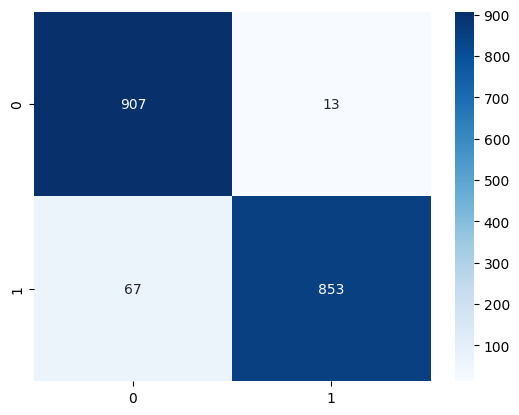

In [25]:
#Generate confusion matrix
cm = metrics.confusion_matrix(Y_test.argmax(axis=1),predictions.argmax(axis=1))
#Visualize the confusion matrix
sns.heatmap(cm,annot=True,fmt="d", cmap = 'Blues')

In [26]:
#1D Convolution Neural Network

cnn = Sequential()
cnn.add(Conv1D(32, kernel_size= 5,activation='relu', input_shape=(178,1)))
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size= 2))
cnn.add(Conv1D(64,kernel_size= 5, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size= 2))
cnn.add(Conv1D(128, kernel_size= 5, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(MaxPooling1D(pool_size= 2))
cnn.add(GlobalAveragePooling1D())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation='softmax'))
cnn.summary()

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 174, 32)             │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 174, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 87, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 83, 64)              │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 83, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 41, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 37, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 37, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 18, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,970 (234.26 KB)

 Trainable params: 59,970 (234.26 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
cnn.fit(X_train, Y_train,validation_data=(X_val, Y_val)
                ,epochs = 10, batch_size = 20
                )

Epoch 1/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8505 - loss: 0.2962 - val_accuracy: 0.8478 - val_loss: 0.3277
Epoch 2/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9531 - loss: 0.1311 - val_accuracy: 0.9245 - val_loss: 0.1790
Epoch 3/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9624 - loss: 0.1046 - val_accuracy: 0.9489 - val_loss: 0.1543
Epoch 4/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9613 - loss: 0.1079 - val_accuracy: 0.9462 - val_loss: 0.1534
Epoch 5/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9647 - loss: 0.0965 - val_accuracy: 0.9614 - val_loss: 0.1135
Epoch 6/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9676 - loss: 0.0880 - val_accuracy: 0.9533 - val_loss: 0.1424
Epoch 7/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9658 - loss: 0.0907 - val_accuracy: 0.9516 - val_loss: 0.1369
Epoch 8/10
736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9698 - loss: 0.0845 - val_accuracy: 0

In [28]:
#Evaluate metrics
train_acc = cnn.evaluate(X_train, Y_train,verbose=1)
val_acc =  cnn.evaluate(X_val,Y_val, verbose=1)

460/460 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9717 - loss: 0.0781
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9632 - loss: 0.0970


In [29]:
#Predict the model on test data

predictions = cnn.predict (X_test)

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [30]:
test_loss, test_acc = cnn.evaluate(X_test,Y_test, verbose=1)
print("Test Accuracy: "+"{:.2%}".format(test_acc))

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9547 - loss: 0.1060
Test Accuracy: 96.63%


<Axes: >

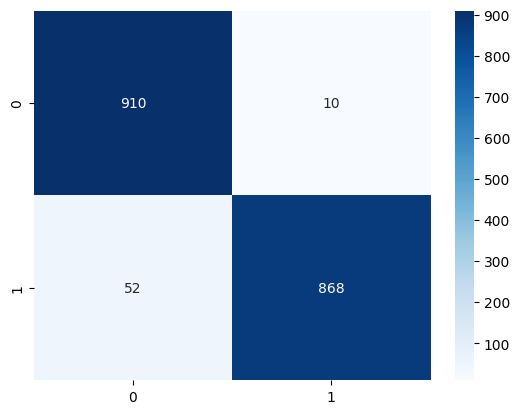

In [31]:
#Generate confusion matrix
cm2 = metrics.confusion_matrix(Y_test.argmax(axis=1),predictions.argmax(axis=1))
#Visualize the confusion matrix
sns.heatmap(cm2,annot=True,fmt="d", cmap = 'Blues')

In [ ]:
#Save models
#model.save('LSTMmodel.keras')
#cnn.save('1Dcnn.keras')

In [ ]:
#Convert model to tensorflow lite format
#import tensorflow as tf

# Convert the model.
#converter = tf.lite.TFLiteConverter.from_keras_model(cnn)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_ops = [
 #  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
   #tf.lite.OpsSet.SELECT_TF_OPS] # enable TensorFlow ops.
#tflite_model = converter.convert()

# Save the model.
#with open('model2.tflite', 'wb') as f:
 # f.write(tflite_model)